# Quantum State Teleportation

Quantum state teleportation is a fundamental protocol in quantum information science. It allows the transfer of an **unknown quantum state** from one party (traditionally called *Alice*) to another party (*Bob*) using two key resources:

1. A pair of qubits that are maximally entangled (an **EPR pair** or **Bell pair**).  
2. A **classical communication channel** between Alice and Bob.

Importantly, the state is transmitted **without physically sending the particle** carrying the state. Instead, the quantum information is destroyed at Alice’s side and perfectly reconstructed at Bob’s side. This does not violate the no-cloning theorem because the original state is not copied, but transferred.

---

## The Protocol

Suppose Alice wants to send an unknown qubit state:

$$
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle, 
\quad \text{where } |\alpha|^2 + |\beta|^2 = 1.
$$

---

### 1. Shared entanglement
Alice and Bob share a maximally entangled Bell state:

$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle).
$$

---

### 2. Joint state
The combined system is:

$$
|\psi\rangle \otimes |\Phi^+\rangle.
$$

This consists of Alice’s unknown qubit and the two entangled qubits (one with Alice, one with Bob).

---

### 3. Bell basis measurement
Alice performs a joint measurement on her two qubits in the Bell basis.  
This projects Bob’s qubit into a state related to $|\psi\rangle$, depending on the measurement outcome.

---

### 4. Classical communication
Alice sends the result of her measurement (2 classical bits) to Bob.

---

### 5. Conditional correction
Bob applies a **Pauli operation** (I, X, Z, or XZ) on his qubit according to Alice’s message.  
After this correction, Bob’s qubit is **exactly** in the state $|\psi\rangle$.

---

## Key Ideas

- The quantum state is not physically transmitted; instead, entanglement plus classical communication make the transfer possible.  
- Two classical bits are always required to teleport one qubit.  
- The process respects the no-cloning theorem: Alice’s original qubit is destroyed in the measurement.  
- Teleportation is a core building block for **quantum communication** and **distributed quantum computing**.




In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity, partial_trace
from qiskit.quantum_info.states.random import random_statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
#del state_fidelity  # removes your custom function
from qiskit_aer.noise import NoiseModel, ReadoutError

from qiskit import __version__
from qiskit_aer import __version__

print("Qiskit version: ", __version__)
print("Qiskit Aer version: ", __version__)

Qiskit version:  0.17.1
Qiskit Aer version:  0.17.1


## Building the Teleportation Circuit

Now that we understand the **theory of quantum teleportation**, let’s start building the actual quantum circuit in Qiskit.

In this step, we:

- Import the required Qiskit classes (`QuantumCircuit`, `QuantumRegister`, `ClassicalRegister`).  
- Define three quantum registers:
  - **psi**: a single qubit that holds the unknown input state $|\psi\rangle$ we want to teleport.  
  - **bell**: two qubits that will be used to create the shared entangled Bell pair between Alice and Bob.  
- Define three classical registers:
  - **cpsi**: to store Alice’s measurement result on the input qubit.  
  - **c**: to store Alice’s measurement result on her half of the Bell pair.  
  - **cphi**: to store Bob’s final measurement result (to check whether teleportation worked).  

We then create a `QuantumCircuit` containing all these registers and initialize (reset) the qubits to the state $|0\rangle$.

Finally, we can **draw** the circuit to confirm the structure.  
If you have `pylatexenc` installed, `qc.draw(output='mpl')` will show a nice diagram; otherwise, `qc.draw()` will show a text-based version.


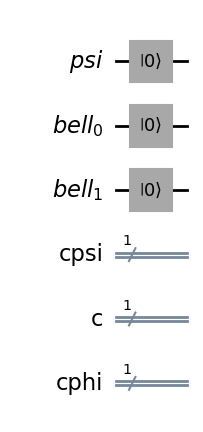

In [5]:
# Register qubits and classical bits
psi = QuantumRegister(1, 'psi')
cpsi = ClassicalRegister(1, 'cpsi')

bell = QuantumRegister(2, 'bell')
c = ClassicalRegister(1, 'c')
cphi = ClassicalRegister(1, 'cphi') #This will be used to read the final result

# Create a quantum circuit
qc = QuantumCircuit(psi, bell, cpsi, c, cphi)
qc.reset(psi)
qc.reset(bell)

qc.draw(output='mpl') #Needs pylatexenc, you can also just call .draw() to get a text representation

## Preparing a Random Input State

To test quantum teleportation, we need to provide an **arbitrary quantum state** $|\psi\rangle$ as the input.  
Instead of always using simple states like $|0\rangle$, $|1\rangle$, or $|+\rangle$, we will generate a **random statevector** on the Bloch sphere.  

Steps in this cell:

1. Use `random_statevector(2)` from `qiskit.quantum_info` to create a normalized complex vector of dimension 2:
   $$
   |\psi\rangle = \alpha |0\rangle + \beta |1\rangle, \quad |\alpha|^2 + |\beta|^2 = 1
   $$
   where $\alpha$ and $\beta$ are random complex amplitudes.  

2. Extract the squared magnitudes $|\alpha|^2$ and $|\beta|^2$ (the measurement probabilities) and store them for reference.

3. Use the `Initialize` instruction to load this random state into the qubit `psi`.

4. Append this initialization to the circuit, so the input qubit is now prepared in the unknown state $|\psi\rangle$ that we will attempt to teleport.

Finally, we draw the updated circuit to see the initialization step included.


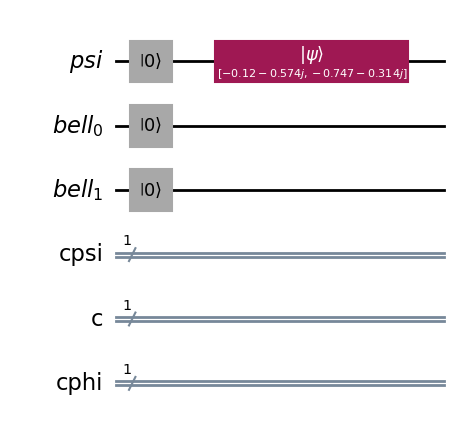

In [7]:
#Generate two random complex numbers
random_vec = random_statevector(2)

#We will store the squared probabilities for future reference
probs = np.abs(random_vec)**2
probs = {0: probs[0], 1: probs[1]}

state = Initialize(random_vec)
qc.append(state, psi)

qc.draw(output='mpl')

## Peeking at the Expected Probabilities

Before running the teleportation protocol, let’s quickly check the measurement probabilities of the input state $|\psi\rangle$.  

These values come from the squared magnitudes of the statevector’s amplitudes ($|\alpha|^2$ and $|\beta|^2$).  
They tell us the **expected outcome frequencies** if we were to directly measure the qubit in the computational basis $\{|0\rangle, |1\rangle\}$.  

This will be useful later, because after teleportation we can compare Bob’s final qubit against these probabilities to verify that the state was transferred correctly.


In [9]:
#Peeking at the expected probabilities

probs

{0: np.float64(0.34385936152631225), 1: np.float64(0.6561406384736879)}

## Creating the Shared Bell Pair

The next step is to create the **entangled resource** that Alice and Bob will share.  
We want qubits `bell[0]` and `bell[1]` to be in the maximally entangled Bell state:

$$
|\Phi^+\rangle = \tfrac{1}{\sqrt{2}}\big(|00\rangle + |11\rangle\big).
$$

To prepare this state:

1. Apply a **Hadamard gate** to `bell[0]`, creating a superposition  
   $$
   |0\rangle \;\;\xrightarrow{H}\;\; \tfrac{1}{\sqrt{2}}(|0\rangle + |1\rangle).
   $$  

2. Apply a **CNOT gate** with `bell[0]` as control and `bell[1]` as target.  
   This entangles the two qubits, producing the Bell state $|\Phi^+\rangle$.

We also add a `barrier()` for visualization so that Qiskit separates this step from the later parts of the circuit.  

Finally, we draw the circuit to confirm the entanglement has been added.


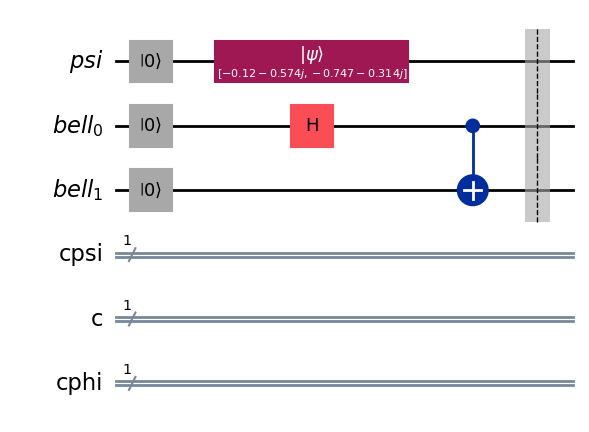

In [11]:
qc.h(bell[0])
qc.cx(bell[0], bell[1])

qc.barrier() #This is just for visualization purposes

qc.draw(output='mpl')

## Alice’s Bell-Basis Measurement Setup

Now we need Alice to perform a **joint operation** on her two qubits:  
- the unknown input qubit `psi`, and  
- her half of the entangled pair `bell[0]`.  

This prepares them to be measured in the **Bell basis**.  

Steps in this cell:

1. Apply a **CNOT gate** with `psi` as the control and `bell[0]` as the target.  
   - This correlates the unknown state with Alice’s entangled qubit.  

2. Apply a **Hadamard gate** to `psi`.  
   - This completes the transformation from the computational basis into the Bell basis.  

Together, these gates ensure that when Alice measures her two qubits, the results will project Bob’s qubit (`bell[1]`) into a state related to $|\psi\rangle$.  

We also insert a `barrier()` for clarity in the circuit diagram so this stage is visually separated.


In [13]:
qc.cx(psi, bell[0])
qc.h(psi)

qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "psi"), index=0>, <Qubit register=(2, "bell"), index=0>, <Qubit register=(2, "bell"), index=1>), clbits=())

## Performing Alice’s Measurement

Now we measure Alice’s two qubits:

1. `bell[0]` → result stored in classical bit `c`.  
2. `psi` → result stored in classical bit `cpsi`.  

These two classical bits together identify **which Bell state** Alice’s qubits collapsed into.  
At this point, Bob’s qubit (`bell[1]`) already contains the teleported state, but it may be “flipped” or “phase-shifted” depending on Alice’s outcomes.  

The measurement outcomes will be sent to Bob over a **classical communication channel**, so he can apply the correct Pauli operation and recover the exact state $|\psi\rangle$.  

We add another barrier to visually separate Alice’s measurement from Bob’s correction step in the circuit diagram.


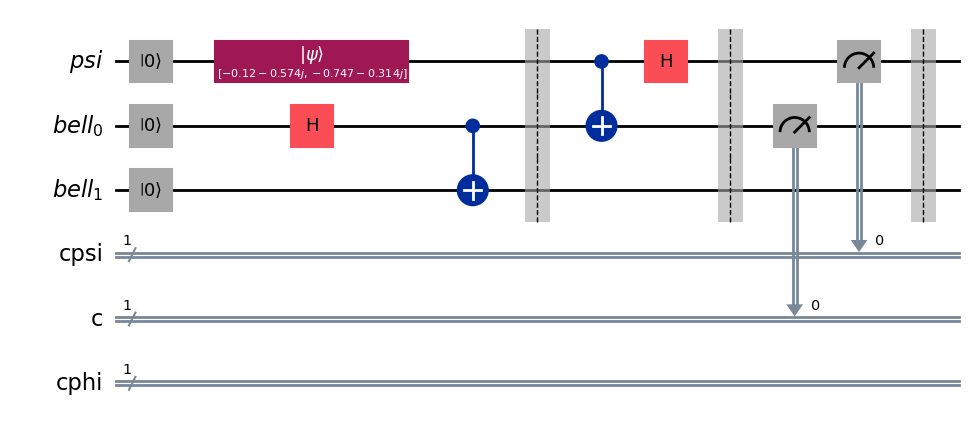

In [15]:
qc.measure(bell[0], c)
qc.measure(psi, cpsi)
qc.barrier()

qc.draw(output='mpl')

## Bob’s Conditional Corrections

At this stage, Bob’s qubit (`bell[1]`) already holds the teleported state,  
but it may have an **extra Pauli error** depending on Alice’s measurement results.  

- If Alice’s measurement outcome was `00`, Bob’s qubit is already in the correct state $|\psi\rangle$.  
- If Alice measured a `01`, Bob needs to apply an $X$ (bit-flip).  
- If Alice measured a `10`, Bob needs to apply a $Z$ (phase-flip).  
- If Alice measured a `11`, Bob needs to apply $XZ$ (both bit- and phase-flip).  

In Qiskit, we use `if_test` blocks to apply these corrections *conditionally* based on the classical bits `c` and `cpsi`.  
This simulates the process of Alice sending **two classical bits** to Bob, who then uses them to decide which correction to apply.  

After this step, Bob’s qubit should be **exactly** in the original state $|\psi\rangle$.


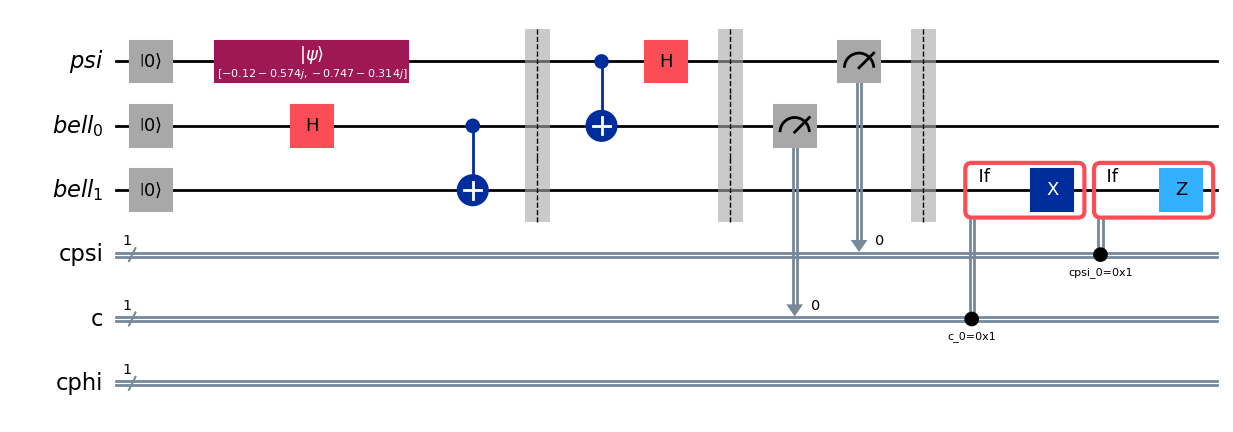

In [17]:
#Decode
# Conditional corrections — use tuple conditions, NOT comparisons
with qc.if_test((c[0], 1)):
    qc.x(2)         

with qc.if_test((cpsi[0], 1)):
    qc.z(2)

# Draw
qc.draw(output="mpl")


## Verifying the Teleportation

Finally, we measure **Bob's qubit** (`bell[1]`) into the classical register `cphi`.  
This allows us to check whether the teleportation worked correctly.

- The qubit `bell[1]` should now be in the same state $|\psi\rangle$ that we originally prepared in `psi`.  
- By measuring it and comparing the outcomes to the **expected probabilities** we stored earlier (`probs`), we can confirm that the quantum state has been successfully transferred.  

This step closes the teleportation protocol:  
Alice’s input qubit has been destroyed by measurement, and Bob’s qubit now holds the teleported state.


<Qubit register=(2, "bell"), index=1>
ClassicalRegister(1, 'cphi')


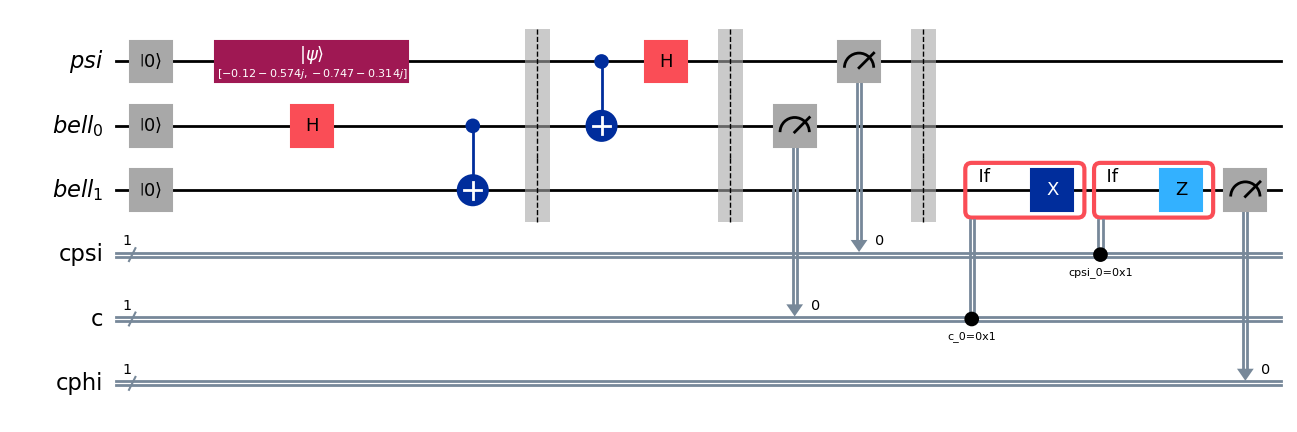

In [19]:
print(bell[1])
print(cphi)
#Measure the final state
qc.measure(bell[1], cphi)

qc.draw(output='mpl')

## Running the Teleportation Circuit on a Simulator

Now that the full teleportation circuit is built, we can **run it on a quantum simulator** to verify the results.

- We use `AerSimulator()` from Qiskit Aer, which can mimic the behavior of an ideal quantum computer.  
- The circuit is executed with a large number of shots (here, 10,000) to get reliable statistics.  
- The output is collected with `result.get_counts()`, which shows the frequencies of measurement outcomes recorded in the classical registers.

By comparing these results with the **expected probabilities** of the original state $|\psi\rangle$, we can confirm that Bob’s qubit has indeed been transformed into the teleported state.


In [21]:

simulator = AerSimulator()
result = simulator.run(qc, shots=10000).result()

print(result.get_counts())

{'0 0 1': 846, '1 0 0': 1633, '1 1 0': 1650, '0 1 1': 790, '1 1 1': 1631, '0 0 0': 909, '0 1 0': 894, '1 0 1': 1647}


In [22]:
# Expected Probabilities Recap from earlier
probs

{0: np.float64(0.34385936152631225), 1: np.float64(0.6561406384736879)}

## Extracting Bob’s Measurement Outcomes

The raw results returned by the simulator contain **all classical registers** (`cpsi`, `c`, `cphi`).  
However, for verifying teleportation we are only interested in **Bob’s final measurement**, stored in `cphi`.

To isolate this:

- We use Python’s `Counter` to collect the frequencies of the outcomes.  
- Since the ordering of classical bits in Qiskit output is inverted, we extract only the **first bit** (corresponding to Bob’s qubit).  
- The counts are normalized (dividing by 1000 here) to make comparison with the expected probabilities easier.

This gives us Bob’s measurement distribution, which we can directly compare to the theoretical probabilities of the input state $|\psi\rangle$.


In [24]:
receiver_counts = Counter()
receiver_counts = Counter()
for k, v in result.get_counts().items():
    receiver_counts[k[0]] += v/1000 #The order is inverted, so the first bit is the last one

## Visualizing Bob’s Measured Probabilites vs the Expected Probabilities

To make the comparison clearer, we plot Bob’s measurement distribution as a histogram.  

- The histogram shows the probabilities of obtaining `0` or `1` when measuring Bob’s qubit.  
- These bars should match the **expected probabilities** we computed earlier for the original input state $|\psi\rangle$.  

If the teleportation worked correctly, the histogram should closely resemble the theoretical distribution.

For comparison, we also plot the **theoretical probabilities** of the original input state $|\psi\rangle$.  

- These values were computed directly from the random statevector’s amplitudes.  
- The histogram shows what we would expect to see if we measured the original qubit in the $\{|0\rangle, |1\rangle\}$ basis.  

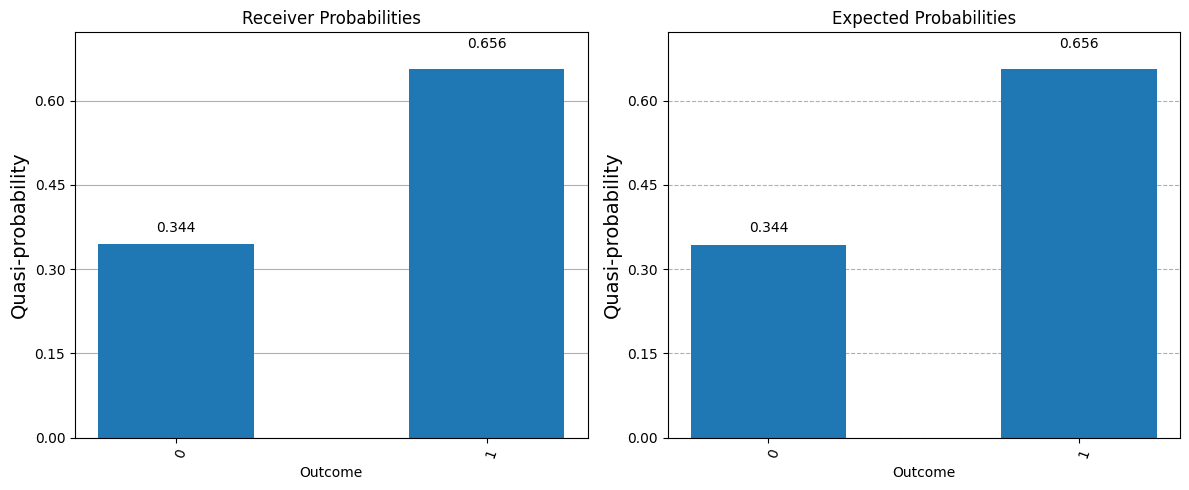

In [26]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Receiver (Bob’s results)
plot_histogram(receiver_counts, ax=axes[0])
axes[0].set_title("Receiver Probabilities")
axes[0].set_xlabel("Outcome")
axes[0].grid(True, axis='y')

# Expected distribution
plot_histogram(probs, ax=axes[1])
axes[1].set_title("Expected Probabilities")
axes[1].set_xlabel("Outcome")
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()


## Conclusion

The side-by-side histograms show that the **measured probabilities of Bob’s qubit** after teleportation (left plot) closely match the **expected probabilities** of the original input state (right plot). This agreement provides strong evidence that the teleportation protocol worked as intended: Alice’s unknown state was transferred to Bob’s qubit using shared entanglement and two bits of classical communication.  

However, it is important to note that **probability distributions alone are not a full test of quantum teleportation**. Measuring only in the computational basis $\{|0\rangle, |1\rangle\}$ reveals whether the outcome frequencies line up, but it does **not capture the full quantum state**. Two different states can produce the same measurement probabilities in one basis, yet be different quantum states overall.  

For this reason, the histograms are only a partial verification. A more accurate way to check whether teleportation succeeded is to compute the **fidelity** between the input state $|\psi\rangle$ and Bob’s output state $\rho_{\text{out}}$. Fidelity measures the overlap between the two states across the entire Bloch sphere, not just in one measurement basis.  

In summary:  
- The plotted results show consistency with teleportation at the level of measurement outcomes.  
- But **fidelity** provides a stronger, basis-independent metric to confirm that the state itself — and not just its statistics in one basis — has been faithfully teleported.  


## Extracting Bob’s Output State for Fidelity

So far, we have only compared measurement probabilities, which does not fully capture whether the quantum state itself was teleported.  
To perform a more rigorous check, we need to examine the **quantum state of Bob’s qubit** after the teleportation protocol.  

In this step:

1. We remove the final measurements from the circuit so that the simulator returns a **coherent quantum state** instead of measurement outcomes.  
2. We run the modified circuit on the **density matrix simulator**, which gives us the full density matrix of all qubits.  
3. Using `partial_trace`, we trace out (discard) all qubits except Bob’s (`bell[1]`), leaving us with his reduced density matrix $\rho_{\text{out}}$.  

This reduced density matrix represents the quantum state that Bob ends up with after teleportation.  
It will allow us to compute the **fidelity** between Bob’s state $\rho_{\text{out}}$ and the original input state $|\psi\rangle$, giving a true measure of how well teleportation succeeded.


In [29]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import DensityMatrix, partial_trace

# Remove final measurements so we get the coherent state
qc_nom = qc.remove_final_measurements(inplace=False)

# Run the circuit on the density matrix simulator
sim = AerSimulator()
qc_nom.save_density_matrix()
tqc = transpile(qc_nom, sim)
res = sim.run(tqc).result()

# Full density matrix of all qubits
dm_full = DensityMatrix(res.data(0)["density_matrix"])

# Find the total number of qubits
n = qc_nom.num_qubits

# Get the index of bell[1] in the circuit
qidx = qc_nom.find_bit(bell[1]).index

# Take the partial trace over *all other qubits* to keep only bell[1]
# subsystems are numbered [0 .. n-1]; we drop everything except qidx
rho_out = partial_trace(dm_full, [i for i in range(n) if i != qidx])

print(rho_out)



DensityMatrix([[0.34385936+0.j        , 0.26961473+0.39106009j],
               [0.26961473-0.39106009j, 0.65614064+0.j        ]],
              dims=(2,))


## Computing the Fidelity

Now that we have Bob’s reduced density matrix $\rho_{\text{out}}$, we can compare it directly with the **original input state** $|\psi\rangle$ to check how well teleportation worked.  

The proper way to quantify this is with **state fidelity**, defined as:

$$
F(\rho_{\text{in}}, \rho_{\text{out}}) 
= \left( \text{Tr}\,\sqrt{\sqrt{\rho_{\text{in}}}\,\rho_{\text{out}}\,\sqrt{\rho_{\text{in}}}} \right)^2.
$$

- If $F = 1$, the states are identical (perfect teleportation).  
- If $F < 1$, the states differ, and the value tells us how close they are.  

In this step:

1. Convert the original random input vector into a normalized `Statevector`.  
2. Ensure that Bob’s output is represented as a `DensityMatrix`.  
3. Use Qiskit’s `state_fidelity` function to compute $F(|\psi\rangle, \rho_{\text{out}})$.  

This gives a **basis-independent, full-state measure** of teleportation success, unlike measurement probabilities which only capture statistics in a single basis.


In [31]:
# random_vec -> normalize & flatten to a 1D statevector
sv = np.asarray(random_vec, dtype=complex).ravel()
sv = sv / np.linalg.norm(sv)

# rho_out should be a 2×2 DensityMatrix (from your partial trace)
rho_out = DensityMatrix(rho_out)  # no-op if it already is

F = state_fidelity(Statevector(sv), rho_out)
print(f"Fidelity F(random_vec, rho_out) = {F:.6f}")


Fidelity F(random_vec, rho_out) = 1.000000


## Fidelity Result (Ideal Case)

We find that the fidelity is essentially **1.0**, which means Bob’s qubit is *exactly* in the state $|\psi\rangle$ that Alice wanted to teleport.  

This is expected in the **ideal (noiseless) simulator**:  
- The protocol implements perfect quantum teleportation.  
- No information is lost, and the state transfer is exact.  

Next, we will extend this analysis by introducing **noise models** into the simulation.  


## Introducing Noise into Teleportation

Up to now, we have been working with an **ideal, noiseless simulator**, where teleportation achieves fidelity = 1.  
However, on real quantum hardware, several types of noise affect circuits and reduce performance.  
We will test three major categories of noise one by one:

1. **Gate errors** (imperfect application of quantum gates)  
2. **Decoherence** (loss of quantum information over time due to relaxation and dephasing)  
3. **Measurement errors** (readout mistakes when converting qubits to classical bits)  

### Step 1: Gate Errors (Depolarizing Noise)
The first noise model we introduce is **gate errors**, represented here by a **depolarizing channel**:
- With probability \(1-p\), the gate works as intended.  
- With probability \(p\), the qubit is randomized (replaced by a maximally mixed state).  

We use two parameters:
- **p1** = error rate for single-qubit gates (H, X, Z, etc.).  
- **p2** = error rate for two-qubit gates (CX).  

Because two-qubit gates are much noisier in practice, we set an example with:  
- \(p1 = 0.002\) (0.2% single-qubit error),  
- \(p2 = 0.01\) (1% two-qubit error).  

### What this cell does
1. Builds a depolarizing **noise model** with chosen error rates.  
2. Runs the teleportation circuit on an **Aer density-matrix simulator** with this noise applied.  
3. Extracts Bob’s output state (using a partial trace).  
4. Computes the **fidelity** between Bob’s noisy state and the original input.  

This serves as a baseline for noisy teleportation. In the next sections, we will add **decoherence** and **measurement errors** to see how each type of noise further affects fidelity.


In [33]:
def make_noise_model(p1=0.002, p2=0.01):
    """
    Build a depolarizing noise model.
    p1 = single-qubit depolarizing probability
    p2 = two-qubit depolarizing probability
    """
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['h','x','z','sx','id'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    return nm

# Example: 0.2% single-qubit error, 1% two-qubit error
noise_model = make_noise_model(p1=0.002, p2=0.01)


# Build simulator with noise + density-matrix method
sim_noisy = AerSimulator(method='density_matrix', noise_model=noise_model)

# Copy circuit and save the density matrix *before* transpile
qc_noisy = qc_nom.copy()
qc_noisy.save_density_matrix(label='rho_final')
qc_noisy.name = "teleport_noisy_dm"   # <-- give it a name to fetch by later

# Let the backend provide its target/basis (don't pass basis_gates)
tqc_noisy = transpile(qc_noisy, backend=sim_noisy, optimization_level=0)

# Run
res_noisy = sim_noisy.run(tqc_noisy).result()

# --- Robust ways to fetch the data ---

# 1) By circuit name (recommended)
data = res_noisy.data("teleport_noisy_dm")

# 2) Alternatively, by the save label
# data = res_noisy.data(0)  # not reliable across versions
# dm_full_noisy = DensityMatrix(data["density_matrix"])  # old default key
# If you saved with a label, prefer:
# dm_full_noisy = DensityMatrix(data["rho_final"])

dm_full_noisy = DensityMatrix(data["rho_final"])

# Extract Bob’s reduced state (same as before)
n_qubits = qc_noisy.num_qubits
qidx_bob = qc_noisy.find_bit(bell[1]).index
rho_out_noisy = partial_trace(dm_full_noisy, [i for i in range(n_qubits) if i != qidx_bob])

# Compare with the intended input state
sv_in = np.asarray(random_vec, dtype=complex).ravel()
sv_in = sv_in / np.linalg.norm(sv_in)
F_noisy = state_fidelity(Statevector(sv_in), DensityMatrix(rho_out_noisy))
print(f"Fidelity with depolarizing gate errors: {F_noisy:.6f}")



Fidelity with depolarizing gate errors: 0.985323


## Why sweep p1 ∈ [0, 2%] and p2 ∈ [0, 5%]?

To study **realistic gate errors**, we sweep:
- **p1 (single‑qubit depolarizing error)** from **0% → 2%**
- **p2 (two‑qubit depolarizing error)** from **0% → 5%**

These ranges reflect typical *order‑of‑magnitude* error rates reported on current superconducting and trapped‑ion devices, where **two‑qubit gates are usually several times noisier** than single‑qubit gates. Teleportation relies critically on **CX gates** (for creating the Bell pair and Alice’s joint operations), so fidelity is expected to be **more sensitive to p2** than to p1.

### What the parameters mean
- **Depolarizing error p**: after a gate, with probability *1−p* the intended gate is applied; with probability *p*, the qubit(s) are randomized (mixed).  
- **p1** applies to single‑qubit gates (H, X, Z, …); **p2** applies to two‑qubit gates (CX).

### How to read the plots
- **Line sweeps**:  
  - *Vary p1, fix p2 = 2%*: shows sensitivity to single‑qubit errors with a moderate two‑qubit error background.  
  - *Vary p2, fix p1 = 0.2%*: shows the dominant impact of two‑qubit errors.
- **Heatmap**: fidelity near **1** in the low‑noise corner; it trends toward **0.5** as errors grow (a fully mixed qubit overlaps any pure state with probability 1/2).

These choices make trends visible without instantly collapsing fidelity, while staying within a plausible “hardware‑like” regime.


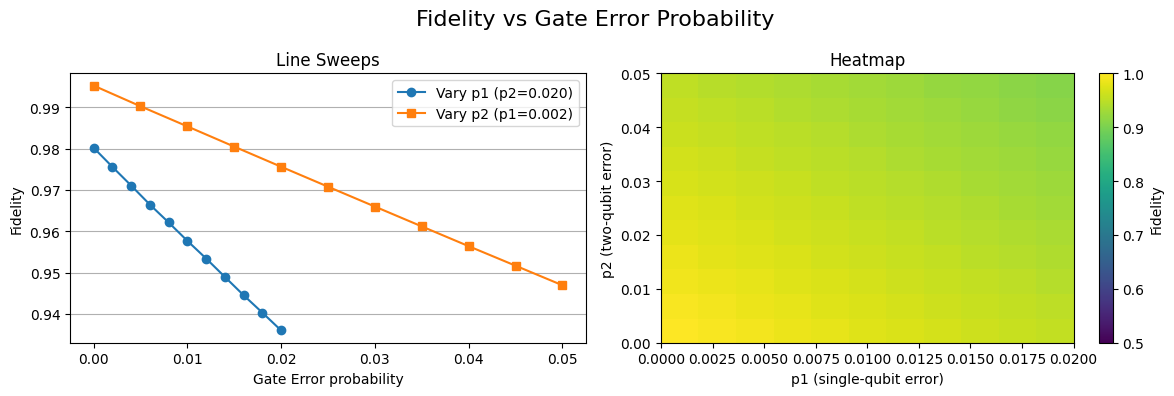

In [35]:
# --- Fidelity sweep over gate error rates and visualization ---

# Input state as a Statevector (from your existing random_vec)
sv_in = np.asarray(random_vec, dtype=complex).ravel()
sv_in = sv_in / np.linalg.norm(sv_in)
psi_in = Statevector(sv_in)

def fidelity_with_errors(p1, p2):
    """Run teleportation with depolarizing gate errors (p1: 1q, p2: 2q) and return fidelity."""
    noise_model = make_noise_model(p1, p2)
    sim = AerSimulator(method='density_matrix', noise_model=noise_model)

    circ = qc_nom.copy()
    circ.save_density_matrix(label='rho_final')
    circ.name = f"teleport_dm_p1_{p1:.5f}_p2_{p2:.5f}"

    tqc = transpile(circ, backend=sim, optimization_level=0)
    res = sim.run(tqc).result()

    data = res.data(circ.name)
    dm_full = DensityMatrix(data['rho_final'])

    # Keep only Bob's qubit bell[1]
    qidx_bob = circ.find_bit(bell[1]).index
    rho_out = partial_trace(dm_full, [i for i in range(circ.num_qubits) if i != qidx_bob])

    return state_fidelity(psi_in, DensityMatrix(rho_out))

# --- Sweep data (assuming you already have fidelity_with_errors, p1_vals, p2_vals) ---

# Line sweeps
p1_vals = np.linspace(0.0, 0.02, 11)
p2_fixed = 0.02
F_p1 = [fidelity_with_errors(p1, p2_fixed) for p1 in p1_vals]

p2_vals = np.linspace(0.0, 0.05, 11)
p1_fixed = 0.002
F_p2 = [fidelity_with_errors(p1_fixed, p2) for p2 in p2_vals]

# Heatmap grid
F_grid = np.zeros((len(p2_vals), len(p1_vals)))
for i, p2 in enumerate(p2_vals):
    for j, p1 in enumerate(p1_vals):
        F_grid[i, j] = fidelity_with_errors(p1, p2)

# --- Side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Add the overall heading to the figure
fig.suptitle('Fidelity vs Gate Error Probability', fontsize=16)

# Left: line sweeps
axes[0].plot(p1_vals, F_p1, marker='o', label=f"Vary p1 (p2={p2_fixed:.3f})")
axes[0].plot(p2_vals, F_p2, marker='s', label=f"Vary p2 (p1={p1_fixed:.3f})")
axes[0].set_xlabel("Gate Error probability")
axes[0].set_ylabel("Fidelity")
axes[0].set_title("Line Sweeps")
axes[0].grid(True, axis='y')
axes[0].legend()

# Right: heatmap
im = axes[1].imshow(F_grid, origin='lower', aspect='auto',
                    extent=[p1_vals.min(), p1_vals.max(),
                            p2_vals.min(), p2_vals.max()],
                    vmin=0.5, vmax=1.0)
axes[1].set_xlabel("p1 (single-qubit error)")
axes[1].set_ylabel("p2 (two-qubit error)")
axes[1].set_title("Heatmap")
cbar = fig.colorbar(im, ax=axes[1])
cbar.set_label("Fidelity")

plt.tight_layout()
plt.show()


## Step 2: Decoherence (T1 / T2 noise)

After exploring **gate errors**, we now introduce another major source of noise in real quantum hardware:  
**decoherence**, which comes from a qubit’s interaction with its environment.

### Types of decoherence
- **Energy relaxation (T1):**  
  A qubit in the excited state $|1\rangle$ can spontaneously decay to the ground state $|0\rangle$ with a characteristic time constant $T_1$.

- **Dephasing (T2):**  
  Even if a qubit does not change energy, its phase coherence can be lost due to random fluctuations, with time constant $T_2$.  
  (Note: physically, $T_2 \leq 2 T_1$ always holds.)

Together, these processes gradually destroy the quantum state, pulling it toward a classical mixture.


### Simulation model
We use Qiskit Aer’s **thermal relaxation error**:
- Noise is applied during the duration of each gate and during measurement.  
- The strength depends on both the coherence times (T₁, T₂) and the gate durations (e.g. single-qubit ~50 ns, two-qubit ~300 ns, measurement ~1000 ns).  

### What this cell does
1. Defines a `make_decoherence_noise_model` function using \(T₁\) and \(T₂\).  
2. Runs the teleportation circuit on a density-matrix simulator with this decoherence noise.  
3. Extracts Bob’s reduced state and computes the **fidelity** with the original input.  
4. Sweeps over different \(T₁\) and \(T₂\) values to show how teleportation fidelity depends on coherence times in line plots.

This lets us see directly how longer coherence times improve teleportation, while shorter \(T₁/T₂\) rapidly degrade fidelity.


Fidelity with decoherence (T1=100.0us, T2=80.0us): 0.984399


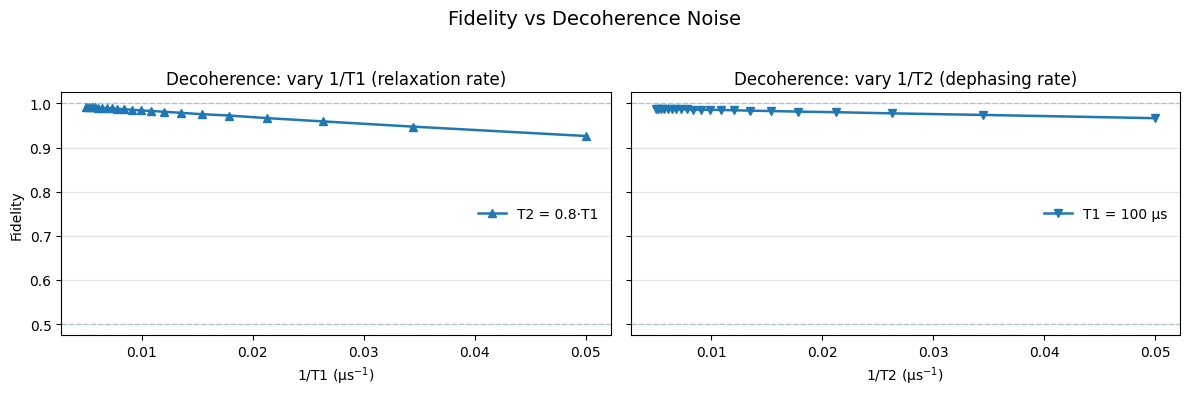

<Figure size 640x480 with 0 Axes>

In [37]:
# === Decoherence noise (T1/T2) and fidelity ===

# --- Helper: build a decoherence (T1/T2) noise model ---
def make_decoherence_noise_model(
    T1_us=100.0, T2_us=80.0,
    t1q_ns=50.0, t2q_ns=300.0, tmeas_ns=1000.0,
    p_excited=0.0,
):
    """
    T1_us, T2_us : coherence times in microseconds (T2 <= 2*T1)
    t1q_ns       : single-qubit gate duration (ns)
    t2q_ns       : two-qubit gate duration (ns)
    tmeas_ns     : measurement duration (ns)
    p_excited    : excited-state population for nonzero temperature (default 0)
    """
    # Convert to seconds
    T1 = T1_us * 1e-6
    T2 = min(T2_us * 1e-6, 2.0 * T1)        # enforce physical bound T2 <= 2*T1
    t1q = t1q_ns * 1e-9
    t2q = t2q_ns * 1e-9
    tmeas = tmeas_ns * 1e-9

    nm = NoiseModel()

    # 1-qubit decoherence during single-qubit gates
    err_1q = thermal_relaxation_error(T1, T2, t1q, p_excited)
    nm.add_all_qubit_quantum_error(err_1q, ['h','x','z','sx','id'])

    # 2-qubit decoherence during CX: apply independent T1/T2 to each qubit
    err_cq = thermal_relaxation_error(T1, T2, t2q, p_excited)
    err_2q = err_cq.tensor(err_cq)  # product noise on both qubits
    nm.add_all_qubit_quantum_error(err_2q, ['cx'])

    # Optional: decoherence during measurement time window
    err_meas = thermal_relaxation_error(T1, T2, tmeas, p_excited)
    nm.add_all_qubit_quantum_error(err_meas, ['measure'])

    return nm

# --- Single run with a chosen T1/T2 to get a baseline noisy fidelity ---
# Typical-ish superconducting numbers (tweak as you like)
T1_us, T2_us = 100.0, 80.0   # coherence times
t1q_ns, t2q_ns, tmeas_ns = 50.0, 300.0, 1000.0

noise_model_dec = make_decoherence_noise_model(T1_us, T2_us, t1q_ns, t2q_ns, tmeas_ns)

sim_dec = AerSimulator(method='density_matrix', noise_model=noise_model_dec)

# Prepare the circuit and save the final density matrix
qc_dec = qc_nom.copy()
qc_dec.save_density_matrix(label='rho_final')
qc_dec.name = "teleport_decoherence_dm"

tqc_dec = transpile(qc_dec, backend=sim_dec, optimization_level=0)
res_dec = sim_dec.run(tqc_dec).result()

data_dec = res_dec.data(qc_dec.name)
dm_full_dec = DensityMatrix(data_dec['rho_final'])

# Reduce to Bob's qubit
qidx_bob = qc_dec.find_bit(bell[1]).index
rho_out_dec = partial_trace(dm_full_dec, [i for i in range(qc_dec.num_qubits) if i != qidx_bob])

# Input state as a Statevector (from your existing random_vec)
sv_in = np.asarray(random_vec, dtype=complex).ravel()
sv_in = sv_in / np.linalg.norm(sv_in)
psi_in = Statevector(sv_in)

F_dec = state_fidelity(psi_in, DensityMatrix(rho_out_dec))
print(f"Fidelity with decoherence (T1={T1_us:.1f}us, T2={T2_us:.1f}us): {F_dec:.6f}")

# --- Sweep helpers ---

def fidelity_with_decoherence(T1_us, T2_us, t1q_ns=50.0, t2q_ns=300.0, tmeas_ns=1000.0, p_excited=0.0):
    """Run teleportation with T1/T2 decoherence and return fidelity."""
    nm = make_decoherence_noise_model(T1_us, T2_us, t1q_ns, t2q_ns, tmeas_ns, p_excited)
    sim = AerSimulator(method='density_matrix', noise_model=nm)

    circ = qc_nom.copy()
    circ.save_density_matrix(label='rho_final')
    circ.name = f"teleport_T1_{T1_us:.1f}_T2_{T2_us:.1f}"

    tqc = transpile(circ, backend=sim, optimization_level=0)
    res = sim.run(tqc).result()
    dm_full = DensityMatrix(res.data(circ.name)['rho_final'])

    qidx_bob = circ.find_bit(bell[1]).index
    rho_out = partial_trace(dm_full, [i for i in range(circ.num_qubits) if i != qidx_bob])

    return state_fidelity(psi_in, DensityMatrix(rho_out))
# ---------- Sweep ranges (times in microseconds) ----------
T1_vals = np.linspace(20.0, 200.0, 10)      # 20..200 µs
T2_vals = np.linspace(20.0, 200.0, 10)      # 20..200 µs
T2_over_T1 = 0.8                             # use T2 = 0.8*T1 for the T1 sweep
T1_fixed = 100.0                             # fix T1 for the T2 sweep

# ---------- Compute fidelities ----------
F_T1 = [fidelity_with_decoherence(T1, T2_over_T1*T1) for T1 in T1_vals]
F_T2 = [fidelity_with_decoherence(T1_fixed, min(T2, 2*T1_fixed)) for T2 in T2_vals]

# Convert to decoherence rates (µs^-1)
R1_vals = 1.0 / T1_vals
R2_vals = 1.0 / T2_vals

# F_grid = np.zeros((len(T2_grid), len(T1_grid)))  # rows: T2, cols: T1
# for i, T2 in enumerate(T2_grid):
#     for j, T1 in enumerate(T1_grid):
#         T2_phys = min(T2, 2*T1)  # enforce T2 <= 2*T1
#         F_grid[i, j] = fidelity_with_decoherence(T1, T2_phys)

# # Convert grid axes to rates
# R1_grid = 1.0 / T1_grid
# R2_grid = 1.0 / T2_grid

# # ---------- Pretty plotting ----------
# plt.rcParams.update({
#     "axes.titlesize": 12,
#     "axes.labelsize": 11,
#     "xtick.labelsize": 10,
#     "ytick.labelsize": 10,
# })

# --------- Decoherence sweeps ---------
T1_vals = np.linspace(20.0, 200.0, 21)    # microseconds
T2_over_T1 = 0.8
F_T1 = [fidelity_with_decoherence(T1, T2_over_T1*T1) for T1 in T1_vals]
R1_vals = 1.0 / T1_vals                   # rates in µs^-1

T2_vals = np.linspace(20.0, 200.0, 21)    # microseconds
T1_fixed = 100.0
F_T2 = [fidelity_with_decoherence(T1_fixed, min(T2, 2*T1_fixed)) for T2 in T2_vals]
R2_vals = 1.0 / T2_vals                   # rates in µs^-1

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle("Fidelity vs Decoherence Noise", fontsize=14)

# Panel A: Fidelity vs 1/T1
ax = axes[0]
ax.plot(R1_vals, F_T1, marker='^', linewidth=1.8, label=f"T2 = {T2_over_T1}·T1")
ax.set_title("Decoherence: vary 1/T1 (relaxation rate)")
ax.set_xlabel("1/T1 (µs$^{-1}$)")
ax.set_ylabel("Fidelity")
ax.grid(True, axis='y', alpha=0.35)
ax.axhline(1.0, linestyle='--', linewidth=1, alpha=0.3)
ax.axhline(0.5, linestyle='--', linewidth=1, alpha=0.3)
ax.legend(frameon=False, loc="best")

# Panel B: Fidelity vs 1/T2
ax = axes[1]
ax.plot(R2_vals, F_T2, marker='v', linewidth=1.8, label=f"T1 = {T1_fixed:.0f} µs")
ax.set_title("Decoherence: vary 1/T2 (dephasing rate)")
ax.set_xlabel("1/T2 (µs$^{-1}$)")
ax.grid(True, axis='y', alpha=0.35)
ax.axhline(1.0, linestyle='--', linewidth=1, alpha=0.3)
ax.axhline(0.5, linestyle='--', linewidth=1, alpha=0.3)
ax.legend(frameon=False, loc="best")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Consistent y-range to emphasize degradation
for ax in axes.ravel():
    ax.set_ylim(0.5, 1.01)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Step 3: Measurement Errors

The third source of noise we test is **measurement error**.  
In real quantum hardware, measurements are not perfectly reliable — a qubit prepared in `|0⟩` may be reported as `1` with some probability, and vice versa. This is usually modeled as a **classical bit-flip channel** acting at the readout stage.

In our teleportation circuit, measurement errors have a particularly strong impact:  
- Alice’s two classical measurement bits determine which conditional corrections Bob applies (`X` and `Z`).  
- If either of Alice’s results is flipped by readout error, Bob may apply the *wrong correction* (or fail to apply the right one).  
- As a result, measurement noise does not just distort the final histogram — it directly corrupts **Bob’s reconstructed quantum state**, lowering the teleportation fidelity.

We will model this effect using Qiskit Aer’s `ReadoutError` noise model, sweeping different error probabilities to see how fidelity degrades as the reliability of Alice’s measurements decreases.
 


State fidelity with measurement error p_ro=0.020: 0.966947


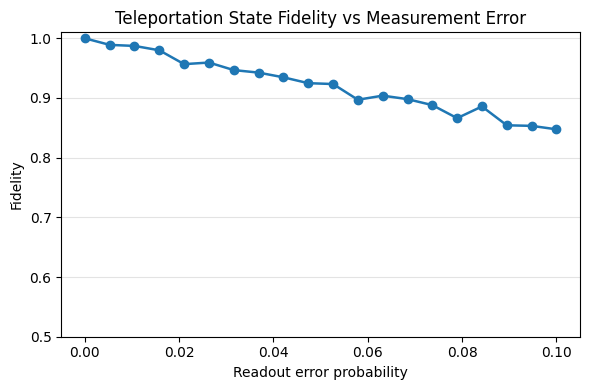

In [39]:
# === Measurement error (readout) and fidelity impact via conditional corrections ===

# --- Helper: symmetric readout-error model ---
def make_readout_noise_model(p_readout=0.02):
    """
    Symmetric confusion matrix:
      P(meas=0 | true=0) = 1 - p
      P(meas=1 | true=0) = p
      P(meas=0 | true=1) = p
      P(meas=1 | true=1) = 1 - p
    Applied to *all* measured qubits.
    """
    nm = NoiseModel()
    confusion = [[1 - p_readout, p_readout],
                 [p_readout,     1 - p_readout]]
    ro_err = ReadoutError(confusion)
    nm.add_all_qubit_readout_error(ro_err)
    return nm

# Prepare input state (from your earlier random_vec)
sv_in = np.asarray(random_vec, dtype=complex).ravel()
sv_in = sv_in / np.linalg.norm(sv_in)
psi_in = Statevector(sv_in)

# --- Single run at a chosen readout error (e.g., 2%) ---
p_ro = 0.02
noise_model_ro = make_readout_noise_model(p_ro)

# Use density-matrix method so we can extract Bob's *quantum state* after wrong/right corrections
sim_ro = AerSimulator(method='density_matrix', noise_model=noise_model_ro)

# Start from qc_nom (Alice's measurements kept; Bob's final measurement removed)
qc_ro = qc_nom.copy()
qc_ro.save_density_matrix(label='rho_final')
qc_ro.name = f"teleport_readout_p{p_ro:.3f}"

tqc_ro = transpile(qc_ro, backend=sim_ro, optimization_level=0)
res_ro = sim_ro.run(tqc_ro).result()

dm_full_ro = DensityMatrix(res_ro.data(qc_ro.name)['rho_final'])

# Reduce to Bob's qubit
qidx_bob = qc_ro.find_bit(bell[1]).index
rho_out_ro = partial_trace(dm_full_ro, [i for i in range(qc_ro.num_qubits) if i != qidx_bob])

F_ro = state_fidelity(psi_in, DensityMatrix(rho_out_ro))
print(f"State fidelity with measurement error p_ro={p_ro:.3f}: {F_ro:.6f}")

# --- Sweep readout error and visualize fidelity drop ---
p_vals = np.linspace(0.0, 0.10, 20)   # 0%..10%
F_vals = []

for p in p_vals:
    nm = make_readout_noise_model(p)
    sim = AerSimulator(method='density_matrix', noise_model=nm)

    circ = qc_nom.copy()
    circ.save_density_matrix(label='rho_final')
    circ.name = f"teleport_readout_p{p:.3f}"

    tqc = transpile(circ, backend=sim, optimization_level=0)
    res = sim.run(tqc).result()
    dm_full = DensityMatrix(res.data(circ.name)['rho_final'])

    qidx = circ.find_bit(bell[1]).index
    rho_out = partial_trace(dm_full, [i for i in range(circ.num_qubits) if i != qidx])

    F_vals.append(state_fidelity(psi_in, DensityMatrix(rho_out)))

# Plot: fidelity vs readout error probability
plt.figure(figsize=(6,4))
plt.plot(p_vals, F_vals, marker='o', linewidth=1.8)
plt.title("Teleportation State Fidelity vs Measurement Error")
plt.xlabel("Readout error probability")
plt.ylabel("Fidelity")
plt.grid(True, axis='y', alpha=0.35)
plt.ylim(0.5, 1.01)  # 0.5 ~ random overlap; 1.0 = perfect
plt.tight_layout()
plt.show()


## Conclusion: Impact of Noise on Teleportation Fidelity

Through our simulations, we investigated how three major classes of noise affect the performance of the quantum teleportation protocol:

1. **Gate Errors (Depolarizing Noise):**  
   Errors on single- and two-qubit gates reduce teleportation fidelity as error probability increases. Since teleportation requires entanglement generation (CX gates) and conditional corrections, two-qubit gate errors in particular have a strong negative impact. The fidelity decreases smoothly with error rate, and even modest error probabilities (∼1–2%) already degrade performance significantly.

2. **Decoherence (T₁ / T₂ processes):**  
   Decoherence due to finite relaxation (T₁) and dephasing (T₂) times also reduces fidelity. Shorter coherence times correspond to higher decoherence rates, leading to an exponential-like decay in fidelity. Relaxation (T₁) primarily causes energy loss, while dephasing (T₂) disrupts phase coherence — both of which are critical for teleportation. As expected, teleportation fidelity remains close to unity only when coherence times are much longer than the circuit depth.

3. **Measurement Errors (Readout Noise):**  
   Readout errors affect the classical communication step in teleportation. Since Bob’s corrective gates (X and Z) are conditioned on Alice’s measurement outcomes, a flipped classical bit leads to incorrect feed-forward operations. This type of noise has a particularly direct and severe effect: even moderate readout error probabilities can sharply reduce fidelity, often driving it toward the classical limit (≈0.5).


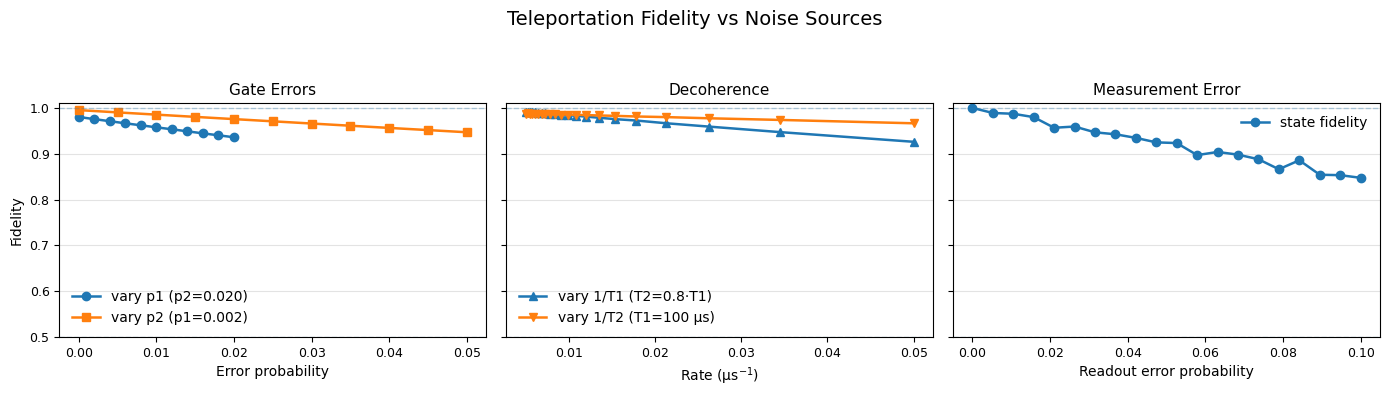

In [41]:
# ---------- Helpers to (re)compute sweeps if needed ----------

def _ensure_gate_sweeps():
    global p1_vals, p2_vals, F_p1, F_p2, p1_fixed, p2_fixed
    try:
        _ = (p1_vals, p2_vals, F_p1, F_p2, p1_fixed, p2_fixed)
    except NameError:
        # Default "realistic" ranges
        p1_vals = np.linspace(0.0, 0.02, 21)   # 0..2%
        p2_vals = np.linspace(0.0, 0.05, 21)   # 0..5%
        p2_fixed = 0.02
        p1_fixed = 0.002
        F_p1 = [fidelity_with_errors(p1, p2_fixed) for p1 in p1_vals]
        F_p2 = [fidelity_with_errors(p1_fixed, p2) for p2 in p2_vals]

def _ensure_deco_sweeps():
    global T1_vals, T2_vals, F_T1, F_T2, R1_vals, R2_vals, T2_over_T1, T1_fixed
    try:
        _ = (T1_vals, T2_vals, F_T1, F_T2, R1_vals, R2_vals, T2_over_T1, T1_fixed)
    except NameError:
        T1_vals = np.linspace(20.0, 200.0, 21)    # µs
        T2_vals = np.linspace(20.0, 200.0, 21)    # µs
        T2_over_T1 = 0.8
        T1_fixed = 100.0
        F_T1 = [fidelity_with_decoherence(T1, T2_over_T1*T1) for T1 in T1_vals]
        F_T2 = [fidelity_with_decoherence(T1_fixed, min(T2, 2*T1_fixed)) for T2 in T2_vals]
        R1_vals = 1.0 / T1_vals
        R2_vals = 1.0 / T2_vals

def _ensure_meas_sweep():
    global p_vals, F_vals
    try:
        _ = (p_vals, F_vals)
    except NameError:
        # Minimal measurement-error sweep (state fidelity via conditional corrections)
        p_vals = np.linspace(0.0, 0.10, 11)
        F_vals = []
        for p in p_vals:
            nm = make_readout_noise_model(p)
            sim = AerSimulator(method='density_matrix', noise_model=nm)
            circ = qc_nom.copy()
            circ.save_density_matrix(label='rho_final')
            circ.name = f"teleport_readout_p{p:.3f}"
            tqc = transpile(circ, backend=sim, optimization_level=0)
            res = sim.run(tqc).result()
            dm_full = DensityMatrix(res.data(circ.name)['rho_final'])
            qidx = circ.find_bit(bell[1]).index
            rho_out = partial_trace(dm_full, [i for i in range(circ.num_qubits) if i != qidx])
            F_vals.append(state_fidelity(psi_in, DensityMatrix(rho_out)))

# Ensure data exists
_ensure_gate_sweeps()
_ensure_deco_sweeps()
_ensure_meas_sweep()

# ---------- Plot: three panels, shared y-axis ----------
plt.rcParams.update({
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
fig.suptitle("Teleportation Fidelity vs Noise Sources", fontsize=14)

# A) Gate errors
ax = axes[0]
ax.plot(p1_vals, F_p1, marker='o', linewidth=1.8, label=f"vary p1 (p2={p2_fixed:.3f})")
ax.plot(p2_vals, F_p2, marker='s', linewidth=1.8, label=f"vary p2 (p1={p1_fixed:.3f})")
ax.set_title("Gate Errors")
ax.set_xlabel("Error probability")
ax.set_ylabel("Fidelity")
ax.grid(True, axis='y', alpha=0.35)
ax.axhline(1.0, linestyle='--', linewidth=1, alpha=0.3)
ax.axhline(0.5, linestyle='--', linewidth=1, alpha=0.3)
ax.legend(frameon=False, loc="best")

# B) Decoherence
ax = axes[1]
ax.plot(R1_vals, F_T1, marker='^', linewidth=1.8, label=f"vary 1/T1 (T2={T2_over_T1}·T1)")
ax.plot(R2_vals, F_T2, marker='v', linewidth=1.8, label=f"vary 1/T2 (T1={T1_fixed:.0f} µs)")
ax.set_title("Decoherence")
ax.set_xlabel("Rate (µs$^{-1}$)")
ax.grid(True, axis='y', alpha=0.35)
ax.axhline(1.0, linestyle='--', linewidth=1, alpha=0.3)
ax.axhline(0.5, linestyle='--', linewidth=1, alpha=0.3)
ax.legend(frameon=False, loc="best")

# C) Measurement error
ax = axes[2]
ax.plot(p_vals, F_vals, marker='o', linewidth=1.8, label="state fidelity")
ax.set_title("Measurement Error")
ax.set_xlabel("Readout error probability")
ax.grid(True, axis='y', alpha=0.35)
ax.axhline(1.0, linestyle='--', linewidth=1, alpha=0.3)
ax.axhline(0.5, linestyle='--', linewidth=1, alpha=0.3)
ax.legend(frameon=False, loc="best")

# Consistent y-range to emphasize degradation
for ax in axes.ravel():
    ax.set_ylim(0.5, 1.01)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


**Overall:**  
All three noise sources degrade teleportation, but in different ways.  
- *Gate errors* accumulate during operations, with two-qubit gates being the most damaging.  
- *Decoherence* sets a time budget for reliable teleportation — operations must complete well within coherence times.  
- *Measurement errors* directly corrupt the classical channel, often producing the most abrupt fidelity loss.  

This demonstrates why error correction and mitigation strategies are essential: without them, teleportation — and quantum communication more broadly — cannot scale reliably.